O modelo salvo após o treinamento da rede neural está armazenado no drive, pois contém 355 MB.

[Baixar modelo_unet.keras](https://drive.google.com/file/d/1HvC_DceK5DHiP7mQzZGtwoQzEYjKrfIu/view?usp=sharing)

In [1]:
import os
import numpy as np
import cv2
from tqdm import tqdm # Mostrar barra de progresso
import matplotlib.pyplot as plt
import tensorflow
import keras
import random
tensorflow.__version__

'2.18.0'

### Pré-processamento dos dados de treino, validação e teste

Para o nosso caso específico, os nossos dados de teste não contém rótulos, ou seja, só temos o X.

In [20]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

SEED = 42 # Definindo seed para reprodutibilidade de resultados
np.random.seed = SEED
random.seed = SEED

PATH_TRAIN = 'data/train/'
PATH_TEST = 'data/test/'

In [21]:
# Adquirimos todos os Ids (caminhos) das imagens de treino e teste
train_ids = next(os.walk(PATH_TRAIN))[1] # Estamos pegando o 2° elemento
test_ids = next(os.walk(PATH_TEST))[1]

In [22]:
# Criando um array composto de zeros onde:
#                       qtd de imagens   altura     largura    canais (rgb)
dataset_img = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

# Fazemos a mesma coisa para as máscaras, porém com apenas 1 canal e o tipo de dados booleano (0 e 1)
dataset_mask = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

dataset_img.shape, dataset_mask.shape # A única diferença é o número de canais

((670, 256, 256, 3), (670, 256, 256, 1))

In [23]:
# Percorre todas as imagens de treino
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = PATH_TRAIN + id_ # Path de cada imagem

    if '.' in path: # Ignorando arquivos .ipynb_checkpoints gerado pelo notebook
        continue

    img = cv2.imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS] # Seleciona apenas os 3 primeiros canais da imagem
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) # Todas as imagens devem ficar em uma resolução padrão (no caso, 256x256)
    dataset_img[n] = img

    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

    # Percorre cada uma das imagens na pasta masks
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = cv2.imread(path + '/masks/' + mask_file)
        mask_ = cv2.cvtColor(mask_, cv2.COLOR_BGR2GRAY) # Converte para escala de cinza
        mask_ = np.expand_dims(cv2.resize(mask_, (IMG_HEIGHT, IMG_WIDTH)), axis=-1) # axis=-1 para adicionarmos mais uma dimensão no final do vetor

        # Atualiza a variável mask com a nova máscara do loop na variável mask_
        # No final, as máscaras serão concatenadas em uma só imagem
        mask = np.maximum(mask, mask_)

    dataset_mask[n] = mask


100%|██████████| 670/670 [00:54<00:00, 12.23it/s]


In [24]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [25]:
# Percorre todas as imagens de teste
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = PATH_TEST + id_ # Path de cada imagem

    if '.' in path: # Ignorando arquivos .ipynb_checkpoints gerado pelo notebook
        continue

    img = cv2.imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS] # Seleciona apenas os 3 primeiros canais da imagem
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) # Todas as imagens devem ficar em uma resolução padrão (no caso, 256x256)
    X_test[n] = img

print(X_test.shape)

100%|██████████| 65/65 [00:00<00:00, 224.14it/s]

(65, 256, 256, 3)


**Separação dos dados entre treino e validação, para adquirir apenas as imagens de validação, da mesma forma que fizemos no notebook de treinamento**

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(dataset_img, dataset_mask,
                                                  test_size=0.2,
                                                  random_state=SEED)

### Visualização de algumas imagens de teste

In [10]:
def show_image(img):
    plt.figure(figsize=(12,6))
    plt.axis('off')
    plt.imshow(img)

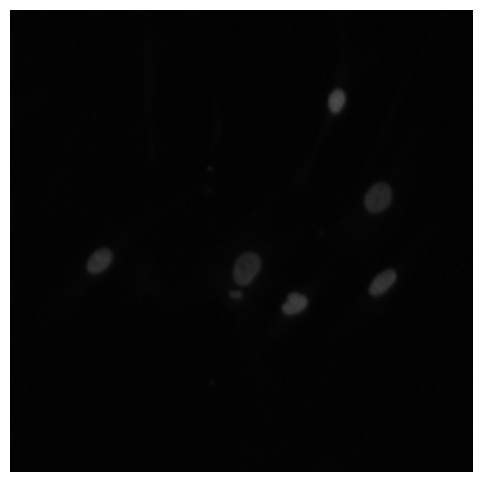

In [11]:
show_image(X_test[0])

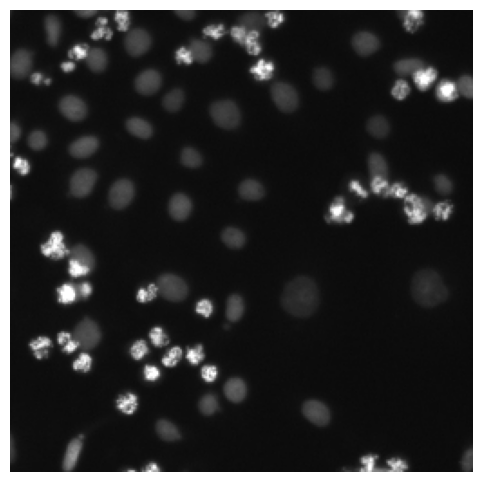

In [14]:
show_image(X_test[64])

In [8]:
model_unet = keras.models.load_model('modelo_unet.keras')
model_unet.summary()

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 93,142,341 (355.31 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

 Optimizer params: 62,087,044 (236.84 MB)

### Dados de teste

In [15]:
predicts_test = model_unet.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step


Como resultado da previsão, temos 65 imagens, de 256x256 pixels com apenas 1 canal (escala de cinza).

O modelo previu as máscaras para cada imagem de teste.

In [16]:
predicts_test.shape

(65, 256, 256, 1)

Pelo fato da função de ativação da camada de saída da rede neural ser uma função *sigmoid*, o retorno para cada elemento (pixel) será um valor dentro do intervalo de 0 a 1. Para o nosso contexto, o valor 0 seria o fundo da imagem, o valor mais próximo de 1 será o objeto segmentado.

Valor mínimo e máximo para a primeira previsão.

In [17]:
predicts_test[0].min(), predicts_test[0].max()

(np.float32(0.0046323957), np.float32(1.0))

Portanto, é necessário converter esses valores entre 0 e 1 para somente, 0 ou 1.

A verificação abaixo é uma condicional, onde caso o valor do elemento seja maior do que 0.5, será 1 (ou true) e caso for menor será 0 (ou false). No final, convertemos o true/false para números inteiros (zero ou um).

In [19]:
predicts_test = (predicts_test > 0.5).astype(np.uint8) # Converte true/false para apenas 0 e 1
predicts_test[0].min(), predicts_test[0].max()

(np.uint8(0), np.uint8(1))

### Dados de validação

In [30]:
# Função para realizar comparação entre imagem original, mascará original e previsão do modelo
def compare_segmentations(original_img, ground_truth, predict):
    fig = plt.figure(figsize=(12,6))
    
    fig.add_subplot(1,3,1) # 1 linha, 3 colunas, índice 1
    plt.imshow(original_img)
    plt.axis('off')
    plt.title('Imagem Original')

    fig.add_subplot(1,3,2) # 1 linha, 3 colunas, índice 2
    # Squeeze para remover a terceira dimensão (canal), pois a imagem já esta em escala de cinza, precisamos apenas da resolução
    plt.imshow(np.squeeze(ground_truth))
    plt.axis('off')
    plt.title('Máscara Original (Ground Truth)')

    fig.add_subplot(1,3,3) # 1 linha, 3 colunas, índice 3
    plt.imshow(np.squeeze(predict))
    plt.axis('off')
    plt.title('Predição')

In [27]:
predicts_val = model_unet.predict(X_val)

5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step


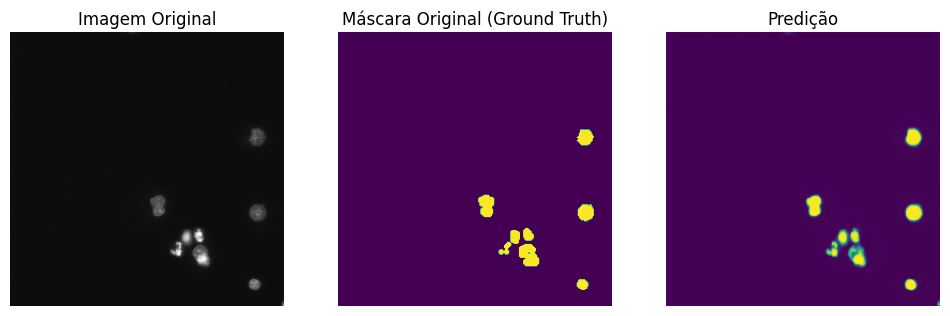

In [31]:
idx = 0
compare_segmentations(X_val[idx], y_val[idx], predicts_val[idx])